In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D


In [13]:
dataset_path = r"C:\Users\Pranav\Desktop\LungCancer_MERN\The IQ-OTHNCCD lung cancer dataset"

raw_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(224,224),
    batch_size=16
)

raw_test = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(224,224),
    batch_size=16
)

# save class names
CLASS_NAMES = raw_train.class_names
print("Classes:", CLASS_NAMES)

# speed up
train_data = raw_train.prefetch(tf.data.AUTOTUNE)
test_data = raw_test.prefetch(tf.data.AUTOTUNE)


Found 1097 files belonging to 3 classes.
Using 878 files for training.
Found 1097 files belonging to 3 classes.
Using 219 files for validation.
Classes: ['Bengin cases', 'Malignant cases', 'Normal cases']


In [14]:
def plot_history(history, model_name):
    acc = history.history.get("accuracy")
    val_acc = history.history.get("val_accuracy")
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")

    plt.figure(figsize=(12,5))

    # ACCURACY
    plt.subplot(1,2,1)
    plt.plot(acc, label="Train Accuracy")
    plt.plot(val_acc, label="Val Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # LOSS
    plt.subplot(1,2,2)
    plt.plot(loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


In [10]:
def evaluate(model, model_name):
    class_names = CLASS_NAMES

    # TRUE LABELS (use raw_test, not prefetched dataset)
    y_true = np.concatenate([y.numpy() for x, y in raw_test], axis=0)
    y_true = np.argmax(y_true, axis=1)

    # PREDICTIONS
    y_pred = np.concatenate([model.predict(x) for x, y in raw_test], axis=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(model_name + " Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # CLASSIFICATION REPORT
    print(classification_report(y_true, y_pred_classes, target_names=class_names))


Epoch 1/2
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6148 - loss: 0.9678 - val_accuracy: 0.8721 - val_loss: 0.4072
Epoch 2/2
55/55 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8458 - loss: 0.3735 - val_accuracy: 0.8904 - val_loss: 0.3226


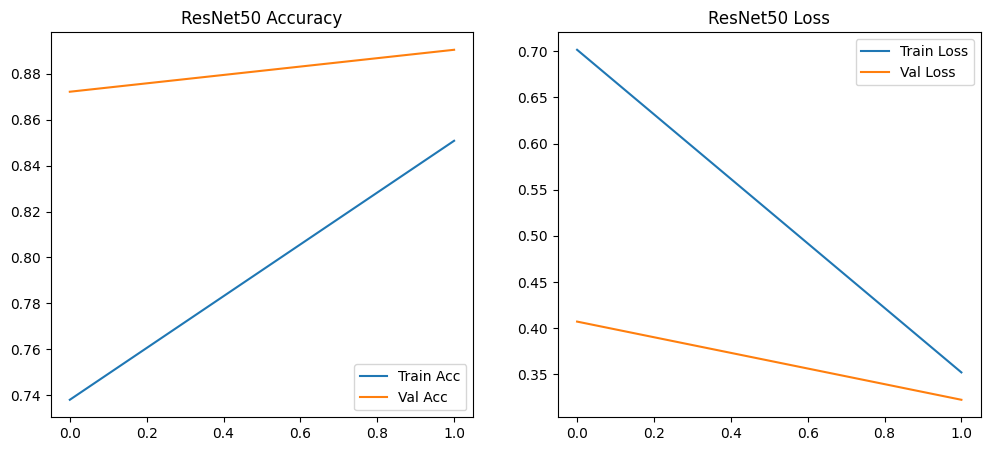

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


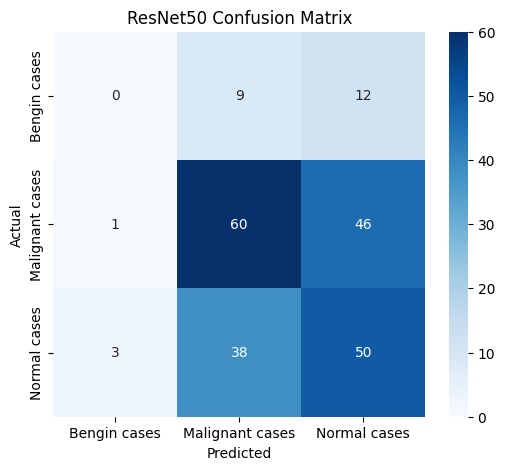

                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        21
Malignant cases       0.56      0.56      0.56       107
   Normal cases       0.46      0.55      0.50        91

       accuracy                           0.50       219
      macro avg       0.34      0.37      0.35       219
   weighted avg       0.47      0.50      0.48       219



In [23]:
from tensorflow.keras.applications import ResNet50

base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(3, activation="softmax")(x)

resnet_model = Model(inputs=base.input, outputs=output)
resnet_model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_resnet = resnet_model.fit(train_data, validation_data=test_data, epochs=2)

resnet_model.save("ResNet50.keras")
plot_history(history_resnet, "ResNet50")

# CORRECT CALL:
evaluate(resnet_model, "ResNet50")



55/55 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.7153 - loss: 5.6587 - val_accuracy: 0.9178 - val_loss: 1.0052


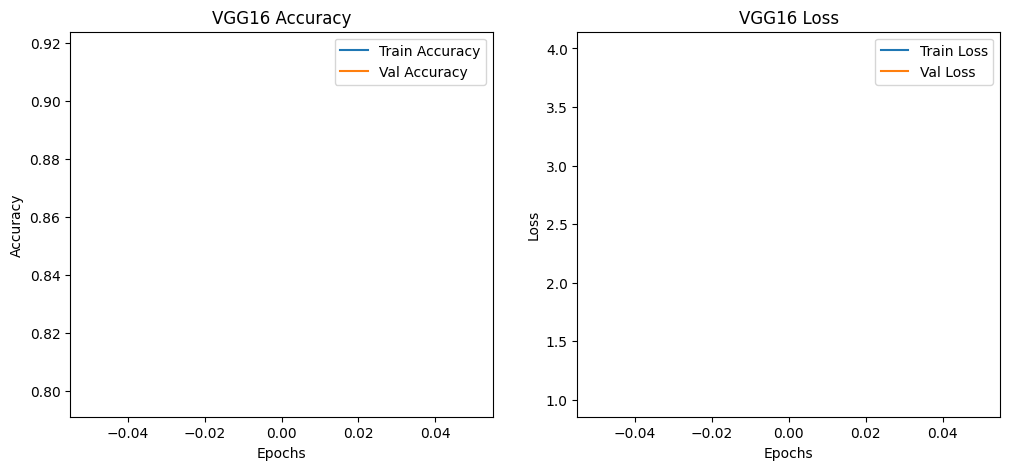

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


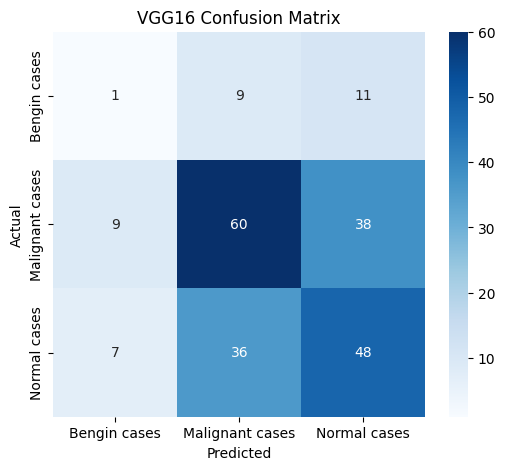

                 precision    recall  f1-score   support

   Bengin cases       0.06      0.05      0.05        21
Malignant cases       0.57      0.56      0.57       107
   Normal cases       0.49      0.53      0.51        91

       accuracy                           0.50       219
      macro avg       0.38      0.38      0.38       219
   weighted avg       0.49      0.50      0.49       219



In [17]:
from tensorflow.keras.applications import VGG16

base = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base.layers:
    layer.trainable = False

x = Flatten()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(3, activation="softmax")(x)

vgg_model = Model(inputs=base.input, outputs=output)
vgg_model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_vgg = vgg_model.fit(train_data, validation_data=test_data, epochs=1)

vgg_model.save("VGG16.keras")
plot_history(history_vgg, "VGG16")
evaluate(vgg_model, "VGG16")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - accuracy: 0.4470 - loss: 24.2377 - val_accuracy: 0.6256 - val_loss: 5.4650


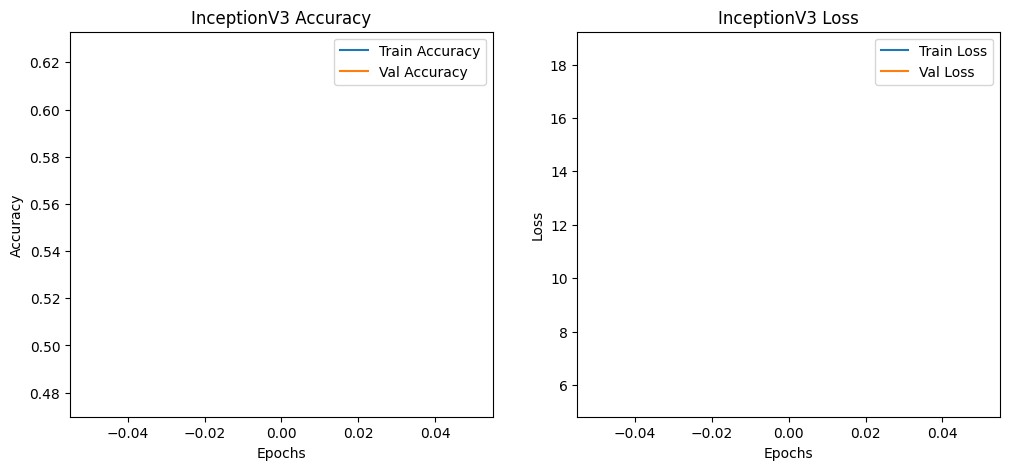

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


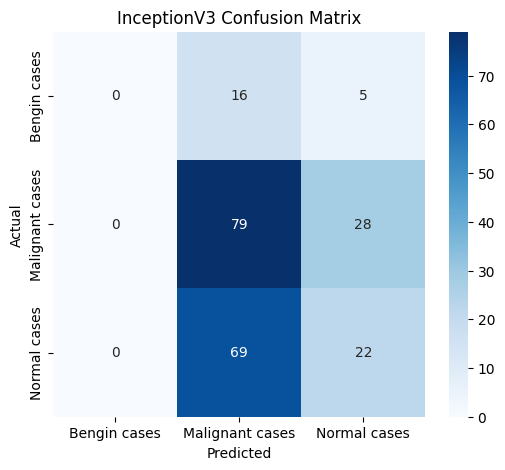

                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        21
Malignant cases       0.48      0.74      0.58       107
   Normal cases       0.40      0.24      0.30        91

       accuracy                           0.46       219
      macro avg       0.29      0.33      0.29       219
   weighted avg       0.40      0.46      0.41       219



c:\Users\Pranav\lungenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Pranav\lungenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Pranav\lungenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [18]:
from tensorflow.keras.applications import InceptionV3

base = InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(3, activation="softmax")(x)

inception_model = Model(inputs=base.input, outputs=output)
inception_model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_inception = inception_model.fit(train_data, validation_data=test_data, epochs=1)

inception_model.save("InceptionV3.keras")
plot_history(history_inception, "InceptionV3")
evaluate(inception_model, "InceptionV3")


In [19]:
print("Model Training Complete!\n")
print("Saved Models:\n")
print("✔ ResNet50.keras")
print("✔ VGG16.keras")
print("✔ InceptionV3.keras")


Model Training Complete!

Saved Models:

✔ ResNet50.keras
✔ VGG16.keras
✔ InceptionV3.keras
